In [42]:
#@title Mount drive

from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [43]:
#@title Metrics utilities

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc


def plot_confusion_matrix(labels, predictions, class_names, save_path=None):
    """
    Plots the confusion matrix. The confusion matrix is annotated with the absolute counts, while colored according
    to the normalized values by row. In this way, even for imbalanced datasets, the diagonal is highlighted well if the
    predictions are good.

    :param labels: numpy array of shape (n_samples,), ground truth (correct labels)
    :param predictions: numpy array of shape (n_samples,), predictions
    :param class_names: list of class names to use as ticks
    :param save_path: path where to save the figure
    """
    cm = confusion_matrix(labels, predictions)
    cm_normalized = cm / cm.sum(axis=1)
    plt.figure()
    sns.heatmap(cm_normalized, annot=cm, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Reds')
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')
    if save_path is not None:
        plt.savefig(save_path / 'confusion_matrix.png')
    plt.show()


def plot_roc(labels, probabilities, save_path=None):
    """
    Plots the ROC curve for binary classification. In case of multi-class labels, the labels should be binarized
    with the respect to a particular class (e.g. labels[:, class_index]).

    :param labels: numpy array of shape (n_samples,), ground truth (correct labels, 1 or 10 or 1)
    :param probabilities: numpy array of shape (n_samples,), probabilities (e.g. softmax activations)
    :param save_path: path where to save the figure
    """
    fpr, tpr, _ = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area={:.2f})'.format(roc_auc), linewidth=2)
    plt.plot([0, 1], [0, 1], label='random choice', linestyle='--', linewidth=2)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid(True)
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path / 'roc.png')
    plt.show()


def make_classification_report(labels, predictions, class_names, save_path=None):
    """
    Generates a classification report including: precision, recall, f1-score, accuracy,

    :param labels: numpy array of shape (n_samples,), ground truth (correct labels)
    :param predictions: numpy array of shape (n_samples,), predictions
    :param class_names: list of class names to use as ticks
    :param save_path: path where to save the figure
    """
    save_path = Path(save_path)
    cr = classification_report(labels, predictions, target_names=class_names)
    print(cr)
    if save_path is not None:
        with open(save_path / 'classification_report.txt', mode='w') as f:
            f.write(cr)


def plot_learning_curves(history, history_ft=None, save_path=None):
    """
    Plots the learning curves for all the metrics contained in history (one figure for each metric).

    :param history: History object returned by tf.keras.Model.fit()
    :param save_path: path where to save the figures
    :param history_ft: History object returned by tf.keras.Model.fit() including the fine-tuning epochs. If this
        argument is provided, history must contain the History object of without the fine-tuning epochs.
    """
    save_path = Path(save_path)
    epochs = history.epoch[-1]

    for metric in history.history.keys():
        if metric.startswith('val_'):
            continue    # already taken into account as dual metric of another one

        val_metric = 'val_' + metric
        train_values = history.history[metric]
        val_values = history.history[val_metric]
        if history_ft is not None:
            train_values += history_ft.history[metric]
            val_values += history_ft.history[val_metric]

        plt.figure()
        plt.plot(train_values, label='training')
        plt.plot(val_values, label='validation')
        if history_ft is not None:
            plt.plot([epochs, epochs], plt.ylim(), label='start fine-tuning')
        plt.xlabel('epoch')
        plt.ylabel(metric)
        plt.legend()
        if save_path is not None:
            plt.savefig(save_path / (metric + '.png'))
        plt.show()


In [44]:
#@title Input pipeline utilities

import numpy as np
import tensorflow as tf
from pathlib import Path

BUFFER_SIZE = 16 * 1024     # 16 KB


def _load_image(filepath, image_size):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.cond(tf.shape(image)[2] == 1, lambda: tf.image.grayscale_to_rgb(image), lambda: image)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)  # keep range [0,255] but as float
    image = (image / 127.5) - 1         # [0,255] -> [-1,1]
    return image


def image_dataset_from_directory(dataset_path, image_size, batch_size, shuffle=True):
    """
    Creates a tf.data.Dataset.

    Each samples is a tuple (image, label), where label is one-hot encoded.
    Gray-scale images are converted to RGB and the possible 4rd channel is dropped. All the images will be RGB.

    :param dataset_path: path to the dataset. The directory must contain one subdirectory for each class.
    :param image_size: tuple (height, width) which the images are resized to
    :param batch_size: integer, batch size
    :param shuffle: bool, whether to shuffle
    :return: tuple (balanced_dataset, class_indices), where class_indices is a dictionary (name -> label)
    """
    dataset_path = Path(dataset_path)
    class_paths = sorted([c for c in dataset_path.iterdir()])
    n_classes = len(class_paths)
    class_indices = {}

    def load_image(filepath):
        return _load_image(filepath, image_size)

    dataset = None
    for label, class_path in enumerate(class_paths):
        class_indices[class_path.name] = label
        label = tf.one_hot(label, n_classes)    # one-hot encoding (for categorical cross entropy)
        class_size = len(list(class_path.iterdir()))
        filepath_ds = tf.data.Dataset.list_files(str(dataset_path / '*/*')).cache()
        if shuffle:
            filepath_ds = filepath_ds.shuffle(BUFFER_SIZE)
        image_ds = filepath_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        label_ds = tf.data.Dataset.from_tensors(label).repeat(class_size)
        class_ds = tf.data.Dataset.zip((image_ds, label_ds))
        dataset = class_ds if dataset is None else dataset.concatenate(class_ds)

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset, class_indices


def image_balanced_dataset_from_directory(dataset_path, image_size, batch_size):
    """
    Creates a tf.data.Dataset generating (infinitely) balanced batches. The strategy used is resampling, i.e. the
    batches are filled by sampling uniformly across different datasets, one for each class.

    Each samples is a tuple (image, label), where label is one-hot encoded.
    Shuffling is enabled, since a balanced dataset is thought to be used for training, not evaluation.
    Gray-scale images are converted to RGB and the possible 4rd channel is dropped. All the images will be RGB.

    :param dataset_path: path to the dataset. The directory must contain one subdirectory for each class.
    :param image_size: tuple (height, width) which the images are resized to
    :param batch_size: integer, batch size
    :return: tuple (balanced_dataset, class_indices, n_batches), where class_indices is a dictionary (name -> label)
        and n_batches is the number of batches required to see all the images at least once
    """
    dataset_path = Path(dataset_path)
    class_paths = sorted([c for c in dataset_path.iterdir()])
    n_classes = len(class_paths)
    n_batches = 0
    class_indices = {}
    datasets = []

    def load_image(filepath):
        return _load_image(filepath, image_size)

    # make one dataset per class
    for label, class_path in enumerate(class_paths):
        class_indices[class_path.name] = label
        label = tf.one_hot(label, n_classes)    # one-hot encoding (for categorical cross entropy)
        class_size = len(list(class_path.iterdir()))
        n_batches = max(n_batches, np.ceil(n_classes * class_size / batch_size))
        image_ds = (
            tf.data.Dataset.list_files(str(class_path / '*'))
            .cache()                            # file paths fit in memory
            .shuffle(BUFFER_SIZE)               # file paths require little memory for shuffling
            .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .repeat()
        )
        label_ds = tf.data.Dataset.from_tensors(label).repeat()
        class_ds = tf.data.Dataset.zip((image_ds, label_ds))
        datasets.append(class_ds)

    # make balanced dataset
    balanced_ds = (
        tf.data.experimental.sample_from_datasets(datasets)     # sample uniformly across the datasets
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return balanced_ds, class_indices, n_batches


In [65]:
#@title Train

from pathlib import Path
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall
from tensorflow_addons.metrics import F1Score

# training settings
BATCH_SIZE = 32
LR = 0.0001
LR_FT = LR / 10             # learning rate for fine-tuning
EPOCHS = 20
EPOCHS_FT = 10              # epochs for fine-tuning
FINE_TUNE_AT = 150          # layer at which to start fine-tuning (layers [0, fine_tune_at-1] are frozen)

IMAGE_SIZE = (224, 224)
INPUT_SHAPE = IMAGE_SIZE + (3,)
VERBOSE = 2


def make_model(n_classes):
    feature_extractor = ResNet50V2(include_top=False, pooling='avg', input_shape=INPUT_SHAPE)
    inputs = Input(shape=INPUT_SHAPE)
    x = feature_extractor(inputs, training=False)           # training=False to keep BN layers in inference mode
    outputs = Dense(n_classes, activation='softmax')(x)     # softmax necessary for AUC metric
    return Model(inputs=inputs, outputs=outputs, name='covidnet')


def get_loss():
    return CategoricalCrossentropy()


def get_metrics(n_classes, covid19_label):
    # remarks:
    # - AUC and F1-score are computed with macro-average (we care a lot about the small COVID-19 class!)
    # - precision and recall are computed only on the COVID-19 class (again, it is the most important)
    return [
        CategoricalAccuracy(name='accuracy'),
        AUC(name='auc', multi_label=True),  # multi_label=True => macro-average
        F1Score(name='f-score', num_classes=n_classes, average='macro'),
        Precision(name='precision', class_id=covid19_label),
        Recall(name='recall', class_id=covid19_label),
    ]


def get_callbacks(model_path, logs_path):
    return [
        ModelCheckpoint(filepath=model_path.with_name(model_path.stem + '-{epoch:02d}-{val_auc:.2f}-{val_f-score:.2f}' +
                                                      model_path.suffix), verbose=VERBOSE),
        EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=VERBOSE),
        TensorBoard(log_dir=logs_path, profile_batch=0)
    ]


def train(model, train_ds, val_ds, learning_rate, epochs, initial_epoch, loss, metrics, callbacks,
          fine_tune=False):
    # set trainable layers
    feature_extractor = model.layers[-2]
    feature_extractor.trainable = False
    if fine_tune:
        feature_extractor.trainable = True      # unfreeze convolutional base
        for layer in feature_extractor.layers[:FINE_TUNE_AT]:
            layer.trainable = False             # freeze bottom layers

    # compile and fit
    model.compile(optimizer=Adam(lr=learning_rate), loss=loss, metrics=metrics)
    model.summary()
    return model.fit(train_ds, epochs=epochs + initial_epoch, initial_epoch=initial_epoch, validation_data=val_ds,
                     callbacks=callbacks)


# prepare paths
dataset_path = Path('/content/gdrive/My Drive/DL/COVID19-project/COVIDx')
model_path = Path('/content/gdrive/My Drive/DL/COVID19-project/models/resnet50v2_new_pipeline')
if model_path.is_dir():
    raise FileExistsError(str(model_path) + ' already exists')
model_path.mkdir(parents=True, exist_ok=True)
logs_path = model_path / 'logs'
plots_path = model_path / 'training'
model_path = model_path / 'model.h5'
plots_path.mkdir()

# build input pipeline
train_ds, classes = image_dataset_from_directory(dataset_path / 'train', IMAGE_SIZE, BATCH_SIZE)
val_ds, _ = image_dataset_from_directory(dataset_path / 'validation', IMAGE_SIZE, BATCH_SIZE, shuffle=False)
n_classes = len(classes)
covid19_label = classes['covid-19']

# compose model
model = make_model(n_classes)

# train top layer and fine-tune
loss = get_loss()
metrics = get_metrics(n_classes, covid19_label)
callbacks = get_callbacks(model_path, logs_path)
history = train(model, train_ds, val_ds, LR, EPOCHS, 0, loss, metrics, callbacks)
history_ft = train(model, train_ds, val_ds, LR_FT, EPOCHS_FT, history.epoch[-1] + 1, loss, metrics,
                       callbacks, fine_tune=True)

print(history.epoch)
print(history_ft.epoch)

# save model and learning curves
model.save(model_path)
plot_learning_curves(history, history_ft, save_path=plots_path)


FileExistsError: ignored

73/73 - 23s


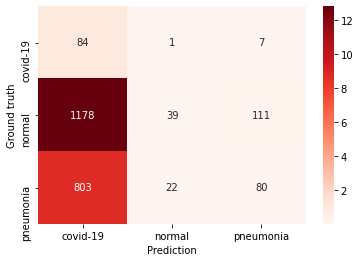

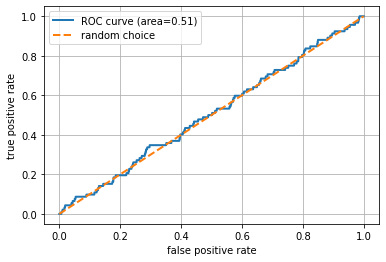

              precision    recall  f1-score   support

    covid-19       0.04      0.91      0.08        92
      normal       0.63      0.03      0.06      1328
   pneumonia       0.40      0.09      0.15       905

    accuracy                           0.09      2325
   macro avg       0.36      0.34      0.09      2325
weighted avg       0.52      0.09      0.09      2325



In [58]:
#@title Evaluate

import numpy as np
from pathlib import Path
from tensorflow.keras.models import load_model

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VERBOSE = 2


def evaluate(model, dataset, output_path, class_names, covid19_label):
    probabilities = model.predict(dataset, verbose=VERBOSE)
    predictions = np.argmax(probabilities, axis=1)
    labels_one_hot = np.array([label.numpy() for _, label in dataset.unbatch()])
    labels = np.argmax(labels_one_hot, axis=1)
    covid19_probabilities = probabilities[:, covid19_label]
    covid19_binary_labels = labels_one_hot[:, covid19_label]

    plot_confusion_matrix(labels, predictions, class_names, save_path=output_path)
    plot_roc(covid19_binary_labels, covid19_probabilities, save_path=output_path)
    make_classification_report(labels, predictions, class_names, save_path=output_path)


# prepare paths
dataset_path = Path('/content/gdrive/My Drive/DL/COVID19-project/COVIDx/test')
model_path = Path('/content/gdrive/My Drive/DL/COVID19-project/models/resnet50v2_new_pipeline/model.h5')
output_path = model_path.parent / 'evaluation'
output_path.mkdir(exist_ok=True)

# build input pipeline
test_ds, class_indices = image_dataset_from_directory(dataset_path, IMAGE_SIZE, BATCH_SIZE, shuffle=False)
class_names = sorted(class_indices.keys())
covid19_label = class_indices['covid-19']

# evaluate
model = load_model(model_path)
evaluate(model, test_ds, output_path, class_names, covid19_label)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/gdrive/My Drive/DL/COVID19-project/logs'